In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model
from transform import TensorAugment, SimpleResize
from models import WDMClassifierTiny
from sklearn.metrics import accuracy_score

In [12]:
cdm_model='Astrid'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'

# Sample indices
all_indices = random.sample(range(15000), 1000)
random.shuffle(all_indices)



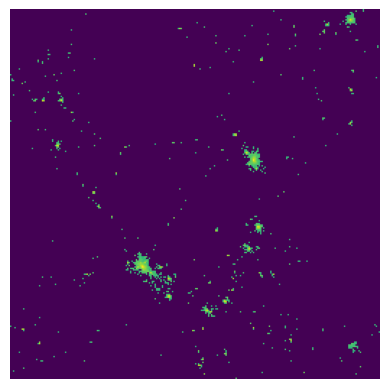

In [20]:
import numpy as np
f1 = np.load(f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy')

plt.imshow(np.log1p(f1[0]))
plt.axis('off')
plt.savefig(f'Mstar.png')
plt.show()

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WDMClassifierTiny().to(device)
checkpoint = torch.load("best_cnn_model_blur_0_tiny.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

WDMClassifierTiny(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(128, 128, kerne

In [58]:
sigmas = np.concatenate([np.linspace(0.0,0.5,10),np.linspace(0.25,0.29,10),np.linspace(0.29,0.35,10)])
sorted_idx = np.argsort(sigmas)
sigmas = sigmas[sorted_idx]
acc = []

In [34]:
sigmas

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.25      , 0.25444444, 0.25888889, 0.26333333, 0.26777778,
       0.27222222, 0.27666667, 0.27777778, 0.28111111, 0.28555556,
       0.29      , 0.29      , 0.29666667, 0.30333333, 0.31      ,
       0.31666667, 0.32333333, 0.33      , 0.33333333, 0.33666667,
       0.34333333, 0.35      , 0.38888889, 0.44444444, 0.5       ])

In [59]:
for s in sigmas:
    
    blur_transform = TensorAugment(
        size=(256, 256),
        p_flip=0.0, # No flipping and rotation for now
        p_rot=0.0,
        noise_std=0, # Stop noise temporarily
        blur_sigma=s,
        apply_log=True,  # Keep log scale
        normalize=False  # Normalize images to [0, 1]
    )
    
    
    test_dataset = load_dataset(all_indices, transform=blur_transform, cdm_file=cdm_file, wdm_file=wdm_file)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                             num_workers=1, pin_memory=True)
    
    # --- Inference and Feature Extraction ---
    all_preds, all_labels, features, softscores = [], [], [], []
    
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
    
            # Feature extraction
            feats = model.features(x)
            pooled = nn.AdaptiveAvgPool2d((1, 1))(feats)  # [B, 128, 1, 1]
            flat_feats = torch.flatten(pooled, 1)         # [B, 128]
    
            # Classifier
            logits = model.classifier[3](flat_feats).squeeze(1)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
    
            # Store outputs
            features.append(flat_feats.cpu())
            softscores.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    
    features = torch.cat(features, dim=0).numpy()
    softscores = np.array(softscores)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # --- Compute Accuracy ---
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Blur sigma {s} Accuracy: {accuracy:.5f}")
    
    acc.append(accuracy)
    with open('acc_vs_sigma.txt','a') as file:
        file.write(f'{cdm_model} {s:.6f} {accuracy:.6f}\n')
    
acc = np.asarray(acc)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 2000 samples
Blur sigma 0.0 Accuracy: 0.66550
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 2000 samples
Blur sigma 0.05555555555555555 Accuracy: 0.66550
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/SIMBA/Maps_Mtot_SIMBA_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1640188/2441737372.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Gaussian blur $\sigma$')


ValueError: x and y must have same first dimension, but have shapes (30,) and (53,)

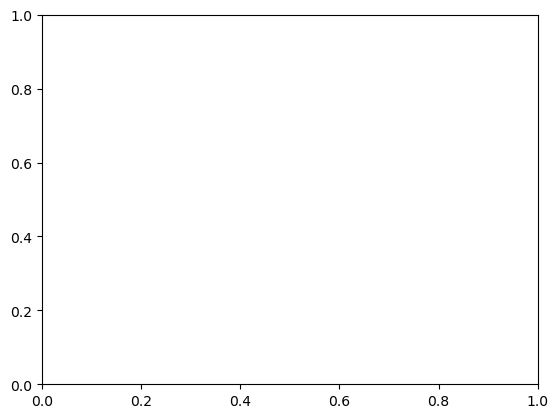

In [54]:
plt.plot(sigmas, acc,marker='o')
plt.plot(np.linspace(0,0.5,10),np.full(10,0.5),color='gray',linestyle='dashed')
plt.xlabel('Gaussian blur $\sigma$')
plt.ylabel('Accuracy')
plt.show()

In [13]:
np.shape(acc)

(30,)

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1917434/3282006154.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Gaussian blur $\sigma$')
/tmp/ipykernel_1917434/3282006154.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


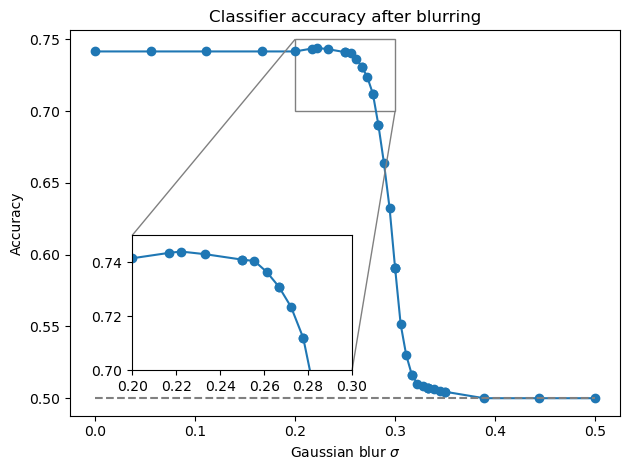

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Main plot
fig, ax = plt.subplots()

# Plot data
ax.plot(sorted_sigma, sorted_acc, marker='o', label='Accuracy')
ax.plot(np.linspace(0, 0.5, 10), np.full(10, 0.5), color='gray', linestyle='dashed', label='Reference')
plt.title('Classifier accuracy after blurring')

# Labels
ax.set_xlabel('Gaussian blur $\sigma$')
ax.set_ylabel('Accuracy')

# --- Inset axes ---
# Define inset size and location (relative to main axes)
axins = inset_axes(ax, width="50%", height="70%", loc='lower left', 
                   bbox_to_anchor=(0.1, 0.1, 0.8, 0.5), bbox_transform=ax.transAxes)

# Plot same data in inset
axins.plot(sorted_sigma, sorted_acc, marker='o')

# Zoom limits (customize this based on your data)
x1, x2 = 0.2, 0.3  # X-axis zoom range
y1, y2 = 0.7, 0.75  # Y-axis zoom range
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)


# Optional: show a rectangle on the main plot to indicate zoom area
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# Show plot
plt.tight_layout()
plt.savefig('blurring.png')
plt.show()


[193 437 594 665 804]
Inflection point at σ = 0.2973, Accuracy = 0.6108


<>:45: SyntaxWarning: invalid escape sequence '\s'
<>:45: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1917434/3680221736.py:45: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Gaussian blur $\sigma$')


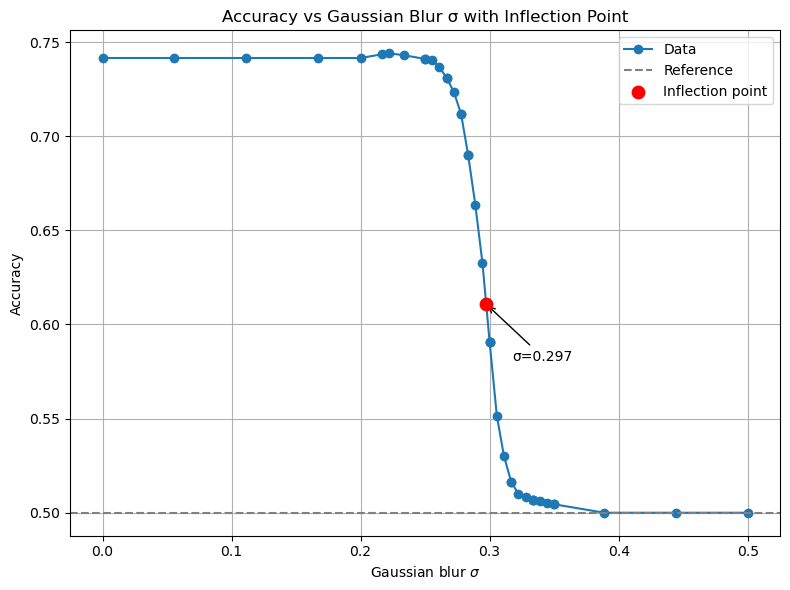

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Your data
x = np.array(sorted_sigma)
y = np.array(sorted_acc)

# --- Interpolate with a smoothing spline ---
# s controls smoothness: s=0 is exact fit; increase to smooth more
spline = UnivariateSpline(x, y, s=1e-4)  # Adjust s as needed

# Dense grid for smooth curve and derivative calculation
x_dense = np.linspace(x.min(), x.max(), 1000)
y_dense = spline(x_dense)
dy = spline.derivative(n=1)(x_dense)
d2y = spline.derivative(n=2)(x_dense)

# --- Find inflection point: where second derivative changes sign ---
indices = np.where(np.diff(np.sign(d2y)))
inflection_indices = indices[0]
print(inflection_indices)

if len(inflection_indices) > 0:
    idx = inflection_indices[2]
    inflect_x = x_dense[idx]
    inflect_y = y_dense[idx]
    print(f"Inflection point at σ = {inflect_x:.4f}, Accuracy = {inflect_y:.4f}")
else:
    inflect_x, inflect_y = None, None
    print("No inflection point detected.")

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(x, y, marker='o', label='Data')
plt.axhline(0.5, color='gray', linestyle='dashed', label='Reference')

# Highlight inflection point if found
if inflect_x is not None:
    plt.scatter([inflect_x], [inflect_y], color='red', s=80, zorder=5, label='Inflection point')
    plt.annotate(f'σ={inflect_x:.3f}', xy=(inflect_x, inflect_y),
                 xytext=(inflect_x + 0.02, inflect_y - 0.03),
                 arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.xlabel('Gaussian blur $\sigma$')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Gaussian Blur σ with Inflection Point')
plt.grid(True)
plt.tight_layout()
plt.show()


<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1917434/3614699134.py:63: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Gaussian blur $\sigma$')
/tmp/ipykernel_1917434/3614699134.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


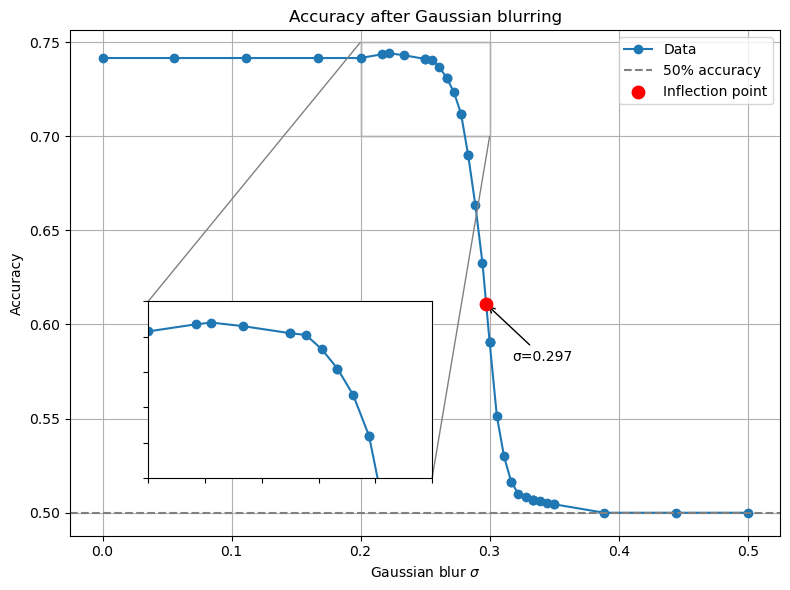

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# --- Data ---
x = np.array(sorted_sigma)
y = np.array(sorted_acc)

# --- Interpolation ---
spline = UnivariateSpline(x, y, s=1e-4)
x_dense = np.linspace(x.min(), x.max(), 1000)
y_dense = spline(x_dense)
d2y = spline.derivative(n=2)(x_dense)

# --- Inflection points ---
inflection_indices = np.where(np.diff(np.sign(d2y)))[0]
inflect_xs = x_dense[inflection_indices]
inflect_ys = y_dense[inflection_indices]

# Optionally select one for main highlight
if len(inflection_indices) >= 3:
    idx = inflection_indices[2]
    main_inflect_x = x_dense[idx]
    main_inflect_y = y_dense[idx]
else:
    main_inflect_x = main_inflect_y = None

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(8, 6))

# --- Main plot ---
ax.plot(x, y, marker='o', label='Data')
ax.axhline(0.5, color='gray', linestyle='dashed', label='50% accuracy')

# Highlight one chosen inflection
if main_inflect_x is not None:
    ax.scatter([main_inflect_x], [main_inflect_y], color='red', s=80, zorder=5, label='Inflection point')
    ax.annotate(f'σ={main_inflect_x:.3f}', xy=(main_inflect_x, main_inflect_y),
                xytext=(main_inflect_x + 0.02, main_inflect_y - 0.03),
                arrowprops=dict(facecolor='red', arrowstyle='->'))

# --- Inset zoom plot ---
axins = inset_axes(ax, width="50%", height="70%", loc='lower left', 
                   bbox_to_anchor=(0.1, 0.1, 0.8, 0.5), bbox_transform=ax.transAxes)

# Inset content
axins.plot(x, y, marker='o')

# Inset zoom limits
x1, x2 = 0.2, 0.3
y1, y2 = 0.7, 0.75
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Turn off tick labels for inset for cleaner look
axins.tick_params(labelleft=False, labelbottom=False)

# Mark zoom region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# --- Final touches ---
ax.set_xlabel('Gaussian blur $\sigma$')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy after Gaussian blurring')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('blur.png')
plt.show()


In [22]:
data = []
with open('acc_vs_sigma.txt','r') as f:
    for line in f.readlines():
        data.append(line.strip().split(' '))

data=np.asarray(data)

<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2125996/3231080639.py:15: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Gaussian blur $\sigma$')


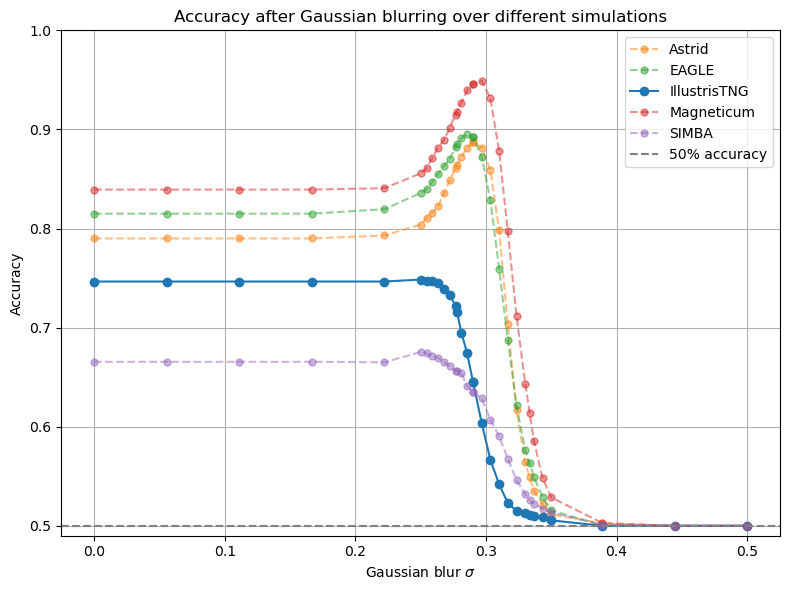

In [69]:
plt.subplots(figsize=(8, 6))

cs=['tab:orange','tab:green','tab:blue','tab:red','tab:purple']

for sim, c in zip(np.unique(data[:,0]),cs):
    d = data[np.where(sim==data[:,0]),1:][0].astype(float)
    if sim=='IllustrisTNG':
        plt.plot(d[:,0],d[:,1], marker='o',label=sim,linestyle='solid',color=c)
    else:
        plt.plot(d[:,0],d[:,1], marker='o',label=sim,ms=5,linestyle='dashed', alpha=0.5, color=c)

plt.axhline(0.5, color='gray', linestyle='dashed', label='50% accuracy')
plt.legend()
plt.ylim(0.49,1)
plt.xlabel('Gaussian blur $\sigma$')
plt.ylabel('Accuracy')
plt.title('Accuracy after Gaussian blurring over different simulations')
plt.grid('True')
plt.tight_layout()
plt.savefig('blur_sims.png')
plt.show()